In [ ]:
# if (!requireNamespace("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install("GEOquery")
# BiocManager::install("Biobase")
# BiocManager::install("ChAMP")
# BiocManager::install("ChAMPdata")

In [ ]:
library(ggplot2)

In [ ]:
library(GEOquery)
library(Biobase)
library(ChAMP)
library(ChAMPdata)
library('ggpubr')
library('scales')

In [ ]:
gset_ra <- getGEO("GSE42861", GSEMatrix=TRUE, getGPL=FALSE)
if (length(gset_ra) > 1) idx <- grep("GPL13534", attr(gset, "names")) else idx <- 1
gset_ra <- gset_ra[[idx]]

In [ ]:
# str(phenoData(gset_ra)@data)
beta_ra = gset_ra@assayData$exprs
dim(beta_ra)

In [205]:
#modified ebGSEA function:

ebGSEA_mod = function(beta = myNorm, pheno = myLoad$pd$Sample_Group, minN = 5, 
          adjPval = 0.05, arraytype = "450K") 
{
  message("ebGSEA function require no NA in beta and pheno parameter.")
    
    
  mapEIDtoCpG <- function(beta, arraytype) {
    if (arraytype == "EPIC") {
      message("  Extracting annotation from IlluminaHumanMethylationEPICilm10b2.hg19.")
      RSobject <- RatioSet(beta, annotation = c(array = "IlluminaHumanMethylationEPIC", 
                                                annotation = "ilm10b2.hg19"))
    }
    else {
      message("  Extracting annotation from IlluminaHumanMethylation450kilmn12.hg19.")
      RSobject <- RatioSet(beta, annotation = c(array = "IlluminaHumanMethylation450k", 
                                                annotation = "ilmn12.hg19"))
    }
    
    #What is the RSobject?
    #Print our the RSanno
    RSanno <- as.data.frame(getAnnotation(RSobject))
    message("  Removing Non-CG probes out of annotation.")
    ann.keep <- RSanno[substr(rownames(RSanno), 1, 2) == 
                         "cg" & RSanno$UCSC_RefGene_Name != "", ]
    message("  Flat all genes on each CpG.")
      
    geneslist <- strsplit(ann.keep$UCSC_RefGene_Name, split = ";")
    names(geneslist) <- rownames(ann.keep)
    grouplist <- strsplit(ann.keep$UCSC_RefGene_Group, split = ";")
    names(grouplist) <- rownames(ann.keep)
    flat <- data.frame(symbol = unlist(geneslist), group = unlist(grouplist))
    flat$symbol <- as.character(flat$symbol)
    flat$group <- as.character(flat$group)
    flat$cpg <- substr(rownames(flat), 1, 10)
    flat$alias <- alias2SymbolTable(flat$symbol)
    message("  Removing all duplicated CpG-genes.")
    id <- paste(flat$cpg, flat$alias, sep = ".")
    d <- duplicated(id)
    flat.u <- flat[!d, ]
    message("  Annotation Prepared.")
    mapEIDtoCpG <- split(flat.u$cpg, flat.u$alias)
    return(mapEIDtoCpG)
  }
    
  mapIslandtoCpG <- function(beta, arraytype) {
    if (arraytype == "EPIC") {
      message("  Extracting annotation from IlluminaHumanMethylationEPICilm10b2.hg19.")
      RSobject <- RatioSet(beta, annotation = c(array = "IlluminaHumanMethylationEPIC", 
                                                annotation = "ilm10b2.hg19"))
    }
    else {
      message("  Extracting annotation from IlluminaHumanMethylation450kilmn12.hg19.")
      RSobject <- RatioSet(beta, annotation = c(array = "IlluminaHumanMethylation450k", 
                                                annotation = "ilmn12.hg19"))
    }
    
    #What is the RSobject?
    #Print our the RSanno
    RSanno <- as.data.frame(getAnnotation(RSobject))
    message("  Removing Non-CG probes out of annotation.")
    ann.keep <- RSanno[substr(rownames(RSanno), 1, 2) == 
                         "cg" & RSanno$UCSC_RefGene_Name != "", ]
    message("  Getting CpG Islands.")
      
    return(ann.keep)
      
    inds = which(ann.keep$Islands_Name != "") # equivalent to Islands_Name != "OpenSea"
    inds_strict = which(ann.keep$Relation_to_Island == "Island")

    island_list <- ann.keep$Islands_Name[inds]
    names(island_list) <- rownames(ann.keep)[inds]

    flat <- data.frame(symbol = unlist(island_list))
    flat$symbol <- as.character(flat$symbol)
    flat$cpg <- substr(rownames(flat), 1, 10)


    mapEIDtoCpG <- split(flat$cpg, flat$symbol)
    return(mapEIDtoCpG)
  }
    
    
  gseaWTfn <- function(termEID.v, rankEID.v, minN = minN) {
    commonEID.v <- intersect(termEID.v, rankEID.v)
    nrep <- length(commonEID.v)
    if (length(commonEID.v) >= minN) {
      otherEID.v <- setdiff(rankEID.v, termEID.v)
      rank1.idx <- match(commonEID.v, rankEID.v)
      rank2.idx <- match(otherEID.v, rankEID.v)
      wilcox <- wilcox.test(rank1.idx, rank2.idx, alt = "less")
      pv <- wilcox$p.value
      n1n2 <- nrep * length(otherEID.v)
      auc <- (n1n2 - wilcox$statistic)/(n1n2)
      pop.v <- 1:length(rankEID.v)
      names(pop.v) <- rankEID.v
      obs.v <- commonEID.v
      pvKPMT <- kpmt::kpmt(pop = pop.v, obs = obs.v, tail = "lower")[[4]]
      out.v <- c(nrep, auc, pv, pvKPMT)
    }
    else {
      out.v <- c(nrep, 0, 1, 1)
    }
    return(out.v)
  }
  message("\n[ Section 1:  Generate Annotation Start ]\n")
  mapEID <- mapIslandtoCpG(beta, arraytype)
  
  #mapEID is a list 19,598 genes, each gene is a list of all the probes mapping to that gene
  
  return(mapEID)
  message("\n[ Section 1:  Gen]=[[[[“““““““““““““““““““““““““““““““““““““                         09erate Annotation Done ]\n")
  message("\n[ Section 2:  Running Global Test Start ]\n")
  if (class(pheno) == "numeric") {
    message("  Applying Linear Model on Global Test. It could be very slow...")
    gt.o <- gt(response = pheno, alternative = t(beta), model = "linear", 
               directional = FALSE, standardize = FALSE, permutations = 0, 
               subsets = mapEID, trace = FALSE)
  }
  else {
    message("  Applying Binary Model on Global Test. It could be very slow...")
    gt.o <- gt(response = (as.numeric(as.factor(pheno)) - 
                             1), alternative = t(beta), model = "logistic", directional = FALSE, 
               standardize = FALSE, permutations = 0, subsets = mapEID, 
               trace = FALSE)
  }
  resGT.m <- result(gt.o)
  tmp.s <- sort(resGT.m[, 1], index.return = TRUE)
  sresGT.m <- resGT.m[tmp.s$ix, ]
  return(sresGT.m)
  message("\n[ Section 2:  Running Global Test Done ]\n")
  message("\n[ Section 3:  GSEA on Pathway Start ]\n")
  message("  Loading MsigDB PathwayList information.")
  data(PathwayList)
  message("  Doing Wilcox Test and Known Population Median Test, it could be slow here.")
  gseaWT.m <- do.call(rbind, lapply(PathwayList, function(x) gseaWTfn(termEID.v = x, 
                                                                      rankEID.v = rownames(sresGT.m), minN = minN)))
  colnames(gseaWT.m) <- c("nREP", "AUC", "P", "P(KPMT)")
  rownames(gseaWT.m) <- names(PathwayList)
  message("  Adjusting Pathway P value with BH method.")
  tmp.s <- sort(gseaWT.m[, 3], decreasing = FALSE, index.return = TRUE)
  sgseaWT.m <- gseaWT.m[tmp.s$ix, ]
  padj.v <- p.adjust(sgseaWT.m[, 3], method = "BH")
  message("  Your adjPval is ", adjPval, ", only pathway below BH adjusted P value 0.05 would be returned.")
  sel.idx <- which(padj.v <= adjPval)
  message("  Forming up final result.")
  if (length(sel.idx) > 1) {
    topGSEAwt.m <- cbind(sgseaWT.m[sel.idx, ], padj.v[sel.idx])
    colnames(topGSEAwt.m) <- c("nREP", "AUC", "P(WT)", "P(KPMT)", 
                               "adjP")
    topGSEAwt.lm <- list()
    topGSEAwt.lm[[1]] <- topGSEAwt.m
    tmp.s <- sort(sgseaWT.m[, 2], decreasing = TRUE, index.return = TRUE)
    topGSEAwt.lm[[2]] <- sgseaWT.m[tmp.s$ix, ]
    names(topGSEAwt.lm) <- c("Rank(P)", "Rank(AUC)")
  }
  else if (length(sel.idx) == 1) {
    topGSEAwt.v <- as.vector(c(sgseaWT.m[sel.idx, ], padj.v[sel.idx]))
    names(topGSEAwt.v) <- c("nREP", "AUC", "P(WT)", "P(KPMT)", 
                            "adjP")
    topGSEAwt.lm <- list(`Rank(P)` = topGSEAwt.v, `Rank(AUC)` = topGSEAwt.v, 
                         POI = rownames(sgseaWT.m)[sel.idx])
  }
  else {
    message("No significant pathway enriched. You may try relax the threshold like adjPva.")
    topGSEAwt.lm <- list()
  }
  message("\n[ Section 3:  GSEA on Pathway Done ]\n")
  return(topGSEAwt.lm)
}


In [199]:
#run the modified ebGSEA function

# x = ebGSEA_mod(beta = beta_ra, pheno=gset@phenoData@data[,40])
# gene_map = ebGSEA_mod(beta = beta_ra, pheno=gset@phenoData@data[,40])
library(globaltest)
ra_gene_level = ebGSEA_mod(beta = beta_ra, pheno=gset@phenoData@data[,40])

ebGSEA function require no NA in beta and pheno parameter.


[ Section 1:  Generate Annotation Start ]


  Extracting annotation from IlluminaHumanMethylation450kilmn12.hg19.

  Removing Non-CG probes out of annotation.

  Flat all genes on each CpG.

Warning message in alias2SymbolTable(flat$symbol):
"Multiple symbols ignored for one or more aliases"
  Removing all duplicated CpG-genes.

  Annotation Prepared.


[ Section 1:  Gen]=[[[[“““““““““““““““““““““““““““““““““““““                         09erate Annotation Done ]



[ Section 2:  Running Global Test Start ]


  Applying Binary Model on Global Test. It could be very slow...



In [ ]:
# length(unique(x$Islands_Name))
x[1:30,c('Islands_Name', 'Relation_to_Island', 'UCSC_RefGene_Group', 'UCSC_RefGene_Name')]
# colnames(x)

#pie chart of all probes and where they lie
# tt = table(x$Relation_to_Island)
# lbls <- paste(names(tt), "\n", paste(round(tt/sum(tt), 2) * 100 , "%"), sep="")
# pie(tt, labels=lbls)



#plot of the distribution of cpg island sizes
# ggplot(data.frame(sizes), aes(x=sizes)) + geom_density(fill="grey") + scale_x_continuous(trans = log10_trans(),
#     breaks = trans_breaks("log10", function(x) 10^x),
#     labels = trans_format("log10", function(x) round(10^x))) + xlab("CpG island Size (log10)") + theme_classic() + coord_fixed(ratio = 0.6)
       

In [ ]:
mapIsland <- split(rownames(x), x$Islands_Name)

In [ ]:
inds = which(x$Islands_Name != "") # equivalent to Islands_Name != "OpenSea"
inds_strict = which(x$Relation_to_Island == "Island")

print(length(inds_strict))
print(length(inds))
print(nrow(x))

island_list <- x$Islands_Name[inds_strict]
names(island_list) <- rownames(x)[inds_strict]

flat <- data.frame(symbol = unlist(island_list))
flat$symbol <- as.character(flat$symbol)
flat$cpg <- substr(rownames(flat), 1, 10)


mapEIDtoCpG <- split(flat$cpg, flat$symbol)
island_probe_num = c()
island_size = c()
for (isl in names(mapEIDtoCpG)){
    island_probe_num = c(island_probe_num, length(mapEIDtoCpG[[isl]]))
    
    r = strsplit(strsplit(isl, ':')[[1]][2], '-')
    island_size = c(island_size, as.numeric(r[[1]][2]) - as.numeric(r[[1]][1]))
}

# hist(log10(island_probe_num))

#plot the relationship between island size and the number of probes
ggplot(data.frame(x = island_probe_num, y = island_size), aes(x=x, y=y)) +
geom_point() + stat_cor(method = "pearson", label.x = 40, label.y = 30000) + 
labs(x="# Probes per Island", y="Island Size")
# names(mapEIDtoCpG)[which.max(island_size)]


In [ ]:
gene_group = sapply(x$UCSC_RefGene_Group, function(x) strsplit(x, ';')[[1]][1])

In [ ]:
#plot the breakdown of where CpGs are around a gene
island_gene = as.data.frame(table(x$Relation_to_Island, gene_group))

ggplot(island_gene, aes(x=factor(Var1, levels=c('Island', 'N_Shore', 'S_Shore', 'N_Shelf', 'S_Shelf', 'OpenSea')), y=Freq, fill=gene_group)) + 
geom_bar(stat="identity", position="fill") + 
labs(x='') +
theme(text = element_text(size=15)) + coord_fixed(ratio=4)



In [200]:
gset_age <- getGEO("GSE40279", GSEMatrix=TRUE, getGPL=FALSE)
if (length(gset_age) > 1) idx <- grep("GPL13534", attr(gset_age, "names")) else idx <- 1
gset_age <- gset_age[[idx]]





# mapIslandtoGene = split(gene_name, x$Islands_Name)

# for (isl in list_of_signif):
#     isl_to_gene = mapIslandtoGene[[isl]][1]

# gene_df = merge(isl_to_gene, ) 

Found 1 file(s)

GSE40279_series_matrix.txt.gz

Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)

See spec(...) for full column specifications.



In [279]:
# x_age = ebGSEA_mod(gset_age@assayData$exprs, pheno=gset_age@phenoData@data[,40])
length(unique(x_age$Islands_Name))

[1] 21013

In [207]:
#to do ::
#create plot of island p-values converted into genes and compare to gene p values 
#create plot of average beta values at each position and then plot based on relation to island, expect to see more methylation in loners
#create plot of significance based on # of probes in island

library(readr)

gene_level = read_csv('ageGT_ComBat.csv')
island_level = read_csv('ageGT_islands.csv')


Attaching package: 'readr'


The following object is masked from 'package:scales':

    col_factor


Warning message:
"Missing column names filled in: 'X1' [1]"
Parsed with column specification:
cols(
  X1 = col_character(),
  `p-value` = col_double(),
  Statistic = col_double(),
  Expected = col_double(),
  Std.dev = col_double(),
  `#Cov` = col_double()
)

Warning message:
"Missing column names filled in: 'X1' [1]"
Parsed with column specification:
cols(
  X1 = col_character(),
  `p-value` = col_double(),
  Statistic = col_double(),
  Expected = col_double(),
  Std.dev = col_double(),
  `#Cov` = col_double()
)



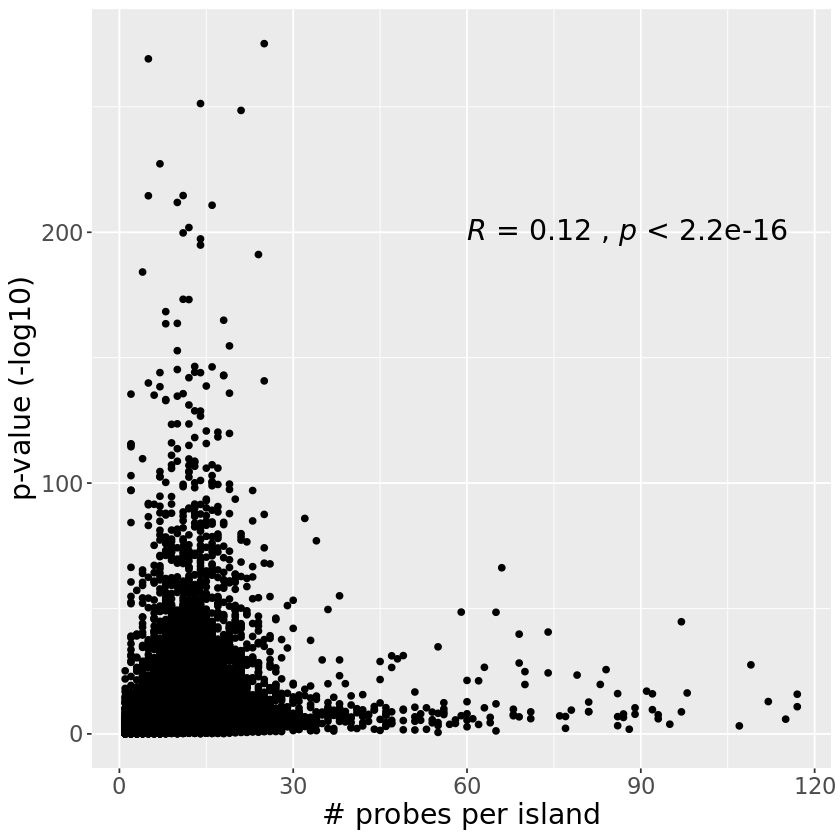

In [225]:
# head(island_level$`#Cov`)
ggplot(island_level, aes(y=-log10(`p-value`), x=`#Cov`)) + geom_point() + 
stat_cor(method = "pearson", label.x = 60, label.y = 200, size=6) + 
theme(text = element_text(size=17)) + 
labs(y='p-value (-log10)', x="# probes per island")

In [280]:
age_gene_name = sapply(x_age$UCSC_RefGene_Name, function(x) strsplit(x, ';')[[1]][1])
# length(unique(x_age$Islands_Name))

In [281]:
inds = which(x_age$Islands_Name != "")

mapIslandtoGene = split(age_gene_name[inds], x_age$Islands_Name[inds])

islandsPerGene = c()
geneOnly_island = c()
for (isl in names(mapIslandtoGene)){
    mapIslandtoGene[[isl]] = unique(mapIslandtoGene[[isl]])
    
    islandsPerGene = c(islandsPerGene, length(unique(mapIslandtoGene[[isl]])))
    geneOnly_island = c(geneOnly_island, unique(mapIslandtoGene[[isl]])[1])
}


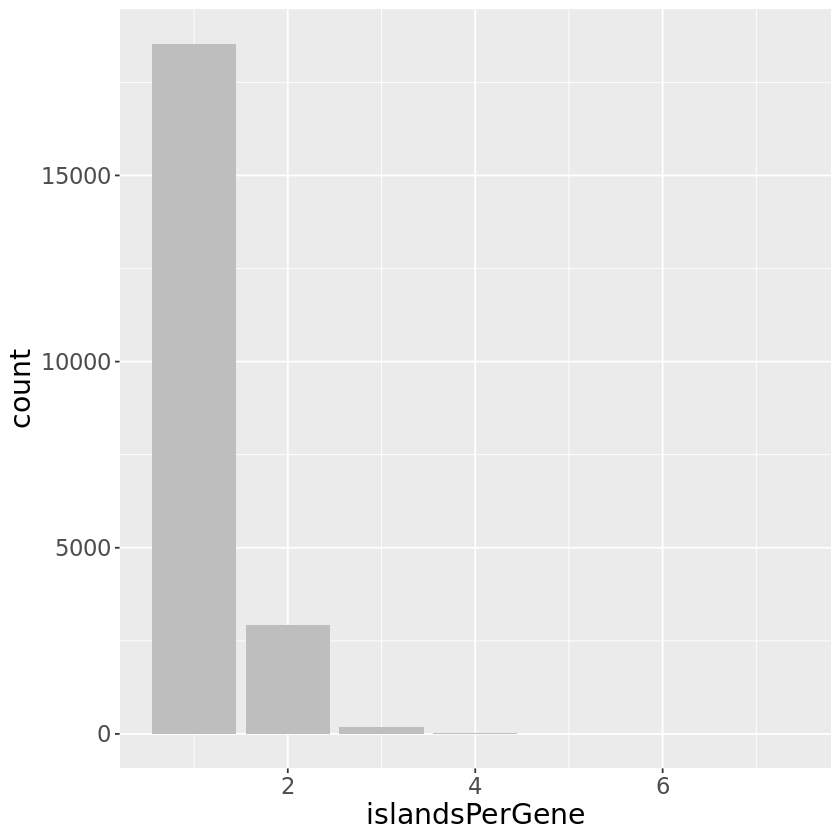

In [252]:
#recreating some of the previous figures:

# inds = which(x_age$Islands_Name != "") # equivalent to Islands_Name != "OpenSea"
# inds_strict = which(x_age$Relation_to_Island == "Island")

# print(length(inds_strict))
# print(length(inds))
# print(nrow(x_age))

# island_list <- x_age$Islands_Name[inds]
# names(island_list) <- rownames(x_age)[inds]

# flat <- data.frame(symbol = unlist(island_list))
# flat$symbol <- as.character(flat$symbol)
# flat$cpg <- substr(rownames(flat), 1, 10)


# mapEIDtoCpG <- split(flat$cpg, flat$symbol)
# island_probe_num = c()
# island_size = c()
# for (isl in names(mapEIDtoCpG)){
#     island_probe_num = c(island_probe_num, length(mapEIDtoCpG[[isl]]))
    
#     r = strsplit(strsplit(isl, ':')[[1]][2], '-')
#     island_size = c(island_size, as.numeric(r[[1]][2]) - as.numeric(r[[1]][1]))
# }

# hist(log10(island_probe_num))

#plot the relationship between island size and the number of probes
# ggplot(data.frame(x = island_probe_num, y = island_size), aes(x=x, y=y)) +
# geom_point() + stat_cor(method = "pearson", label.x = 40, label.y = 30000, size=6) + 
# labs(x="# Probes per Island", y="Island Size") + 
# theme(text = element_text(size=17))

ggplot(data.frame(islandsPerGene), aes(x=islandsPerGene)) + geom_bar(fill="grey") + 
    theme(text = element_text(size=17))
#     scale_x_continuous(trans = log10_trans(),
#     breaks = trans_breaks("log10", function(x) 10^x),
#     labels = trans_format("log10", function(x) round(10^x))) + xlab("CpG island Size (log10)") + theme_classic() + coord_fixed(ratio = 0.6)
       

g.X1,g.p-value,g.Statistic,g.Expected,g.Std.dev,g.#Cov
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
UROD,2.769559e-131,4.782921,0.1526718,0.16067756,14
ELOVL2,1.071813e-120,10.820257,0.1526718,0.08812760,15
MIR770,1.019922e-94,7.732023,0.1526718,0.16730127,5
FHL2,6.917865e-90,5.576227,0.1526718,0.07101935,34
ALDH1A1,2.026934e-84,10.809337,0.1526718,0.18144395,2
APOL1,6.418344e-74,5.720432,0.1526718,0.09690953,10


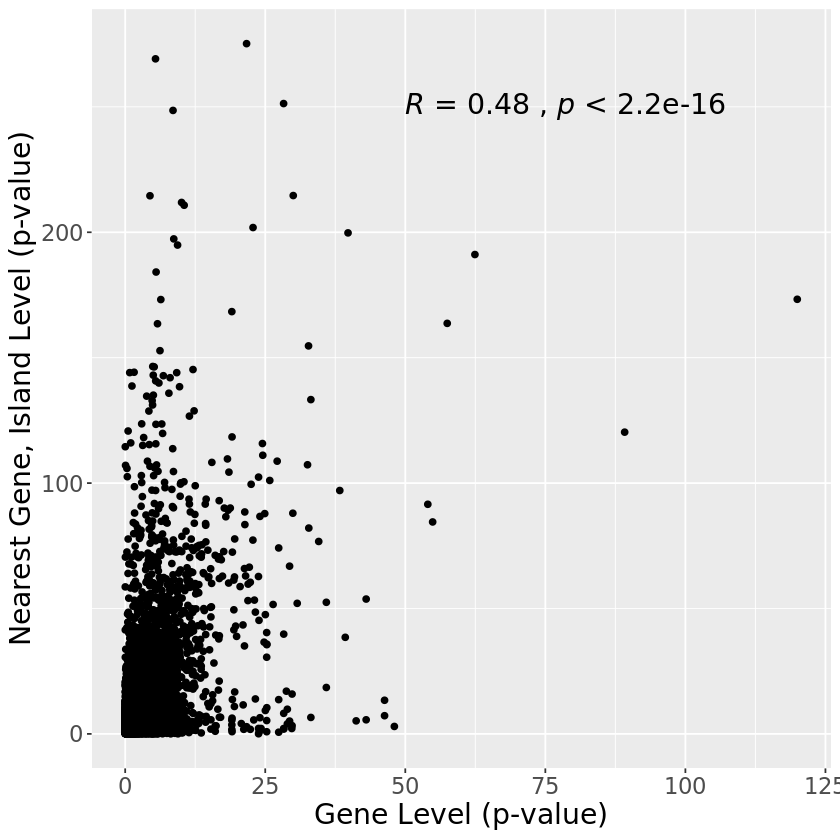

In [282]:
ig_df = data.frame(island=names(mapIslandtoGene), gene=geneOnly_island)
ig_wpval = merge(island_level[,c('X1', 'p-value')], ig_df, by.x='X1', by.y='island')

# colnames(gene_level) = paste('g.', colnames(gene_level), sep="")
head(gene_level)

final = merge(ig_wpval, gene_level[,c('g.X1', 'g.p-value')], by.x='gene', by.y='g.X1')

ggplot(final, aes(x=-log10(`g.p-value`), y=-log10(`p-value`))) + geom_point() +
    stat_cor(method = "pearson", label.x = 50, label.y = 250, size=6) + 
    labs(x="Gene Level (p-value)", y='Nearest Gene, Island Level (p-value)') +
    theme(text = element_text(size=17))


# 1 – (rank-1)/n

# final$g.rank = 1 - (rank(final$`g.p-value`) - 1)/nrow(final)
# final$i.rank = 1 - (rank(final$`p-value`) - 1)/nrow(final)
# head(final)

# ggplot(final, aes(x=g.rank, y=i.rank)) + geom_point() +
# #     stat_cor(method = "pearson", label.x = 50, label.y = 250, size=6) + 
#     labs(x="Gene Level (rank)", y='Nearest Gene, Island Level (rank)') +
#     theme(text = element_text(size=17))



In [293]:
avgs = rowSums(gset_age@assayData$exprs)/ncol(gset_age@assayData$exprs)
avg_df = data.frame(cpg_id = names(avgs), val = avgs)
head(x_age)

both = merge(avg_df, x_age[, c('Name', 'Relation_to_Island')], by.x='cpg_id', by.y='Name')
head(both)

,chr,pos,strand,Name,AddressA,AddressB,ProbeSeqA,ProbeSeqB,Type,NextBase,⋯,UCSC_RefGene_Name,UCSC_RefGene_Accession,UCSC_RefGene_Group,Phantom,DMR,Enhancer,HMM_Island,Regulatory_Feature_Name,Regulatory_Feature_Group,DHS
,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
cg00000029,chr16,53468112,+,cg00000029,14782418,,AACTATACTAACRAAAAAATATCCAAAAAACACTAACRTATAAAAATTTC,,II,,⋯,RBL2,NM_005611,TSS1500,,,,,16:53467838-53469685,Promoter_Associated,TRUE
cg00000108,chr3,37459206,+,cg00000108,12709357,,ATACAATAAAACAAACCTAAAATAATCCTAACTCCRCTATCATCCTAACC,,II,,⋯,C3orf35;C3orf35,NM_178339;NM_178342,Body;3'UTR,,,,,,,
cg00000109,chr3,171916037,+,cg00000109,59755374,,CAATACTAACAAACACATATACCCCCCCACAAATCTTAACTTCTAAATAC,,II,,⋯,FNDC3B;FNDC3B,NM_001135095;NM_022763,Body;Body,low-CpG:173398671-173398760,,,,,,
cg00000236,chr8,42263294,-,cg00000236,12649348,,TATAACRTCATATTAAAAAAAACRATCTAACCCACCAATTTATACATCAC,,II,,⋯,VDAC3;VDAC3,NM_005662;NM_001135694,3'UTR;3'UTR,,,,,,,
cg00000289,chr14,69341139,+,cg00000289,18766346,,ATCTACTATATTCATTTCTCCAATCTCATATCCATTTTAATATAAAAATC,,II,,⋯,ACTN1;ACTN1;ACTN1,NM_001130005;NM_001130004;NM_001102,3'UTR;3'UTR;3'UTR,,,,,,,
cg00000292,chr16,28890100,+,cg00000292,43764508,,AAAACATTAATTACCAACCRCTCTTCCAAAAAACACTTACCATTAAAACC,,II,,⋯,ATP2A1;ATP2A1,NM_004320;NM_173201,1stExon;1stExon,,,,,,,


cpg_id,val,Relation_to_Island
<fct>,<dbl>,<chr>
cg00000029,0.4760974,N_Shore
cg00000108,0.9443131,OpenSea
cg00000109,0.8929125,OpenSea
cg00000236,0.7464122,OpenSea
cg00000289,0.6097531,N_Shore
cg00000292,0.8263536,N_Shore


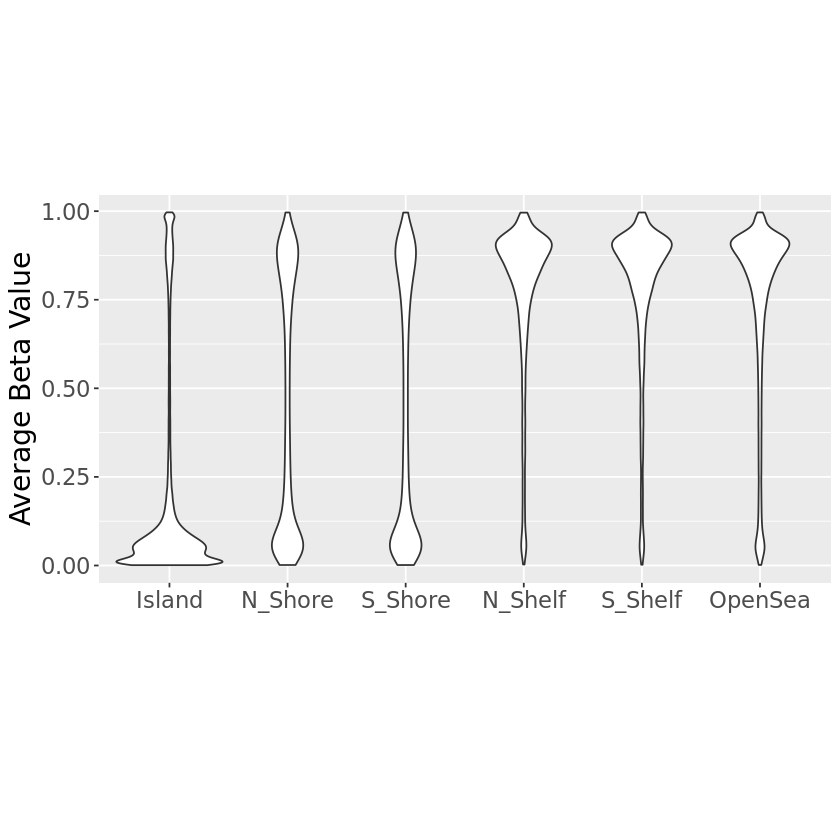

In [302]:
ggplot(both, aes(x=factor(Relation_to_Island, levels=c('Island', 'N_Shore', 'S_Shore', 'N_Shelf', 'S_Shelf', 'OpenSea')), y=val)) + geom_violin() + 
    labs(x="",y='Average Beta Value') +
    theme(text = element_text(size=17)) + coord_fixed(ratio=3)

# locs = unique(both$Relation_to_Island)
# total_avgs = c()
# for (lo in locs){
#     total_avgs = c(total_avgs, )
# }